# 0. Introduction

## Goal

This notebook aims to present how data stored in non formatted documents could be leveraged to improve data quality inside the PIM.

This notebook uses a handful of modules developped inside this project.

## What pipeline?

The different steps for this project are as follows:

1. fetch all product IDs from PIM with the associated ingredient lists
- split the products between a train set and a test set
- train the algorithm on the train set: i.e. construct the vocabulary
- make it make prediction on the test set
- compare it with the ingredient list on this product

# 1. Fetching the data

We will use production data for training and testing of this model. The ID of the products are the PIM uid, and therefore are listed in the directory of the PIM-API module.

First, let's get those uids.

In [1]:
from src import pimapi
requester = pimapi.Requester('prd')
requester.refresh_directory()
requester._directory

Done


,type,title,lastModified,lastRefreshed,lastFetchedData,lastFetchedFiles
uid,,,,,,
58f67e91-6d16-4f12-97c7-e67d24be6805,pomProduct,Curcuma moulu en sac 1 kg LA CASE AUX EPICES,2019-12-06 11:24:21.231000+00:00,2020-02-17 08:00:41.451779+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
f46327cf-8f3c-4b67-85fa-7e6e6daaf618,pomProduct,Pique à viande bleu en sachet de 100 HIPPOPOTAMUS,2020-01-06 14:52:29.288000+00:00,2020-02-17 08:00:41.451779+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
58a1ae66-ca4d-4d82-9d30-4073b1edaeb8,pomProduct,Pique à viande rouge en sachet de 100 HIPPOPOT...,2020-01-06 14:52:48.715000+00:00,2020-02-17 08:00:41.451779+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
9bc59474-7839-458b-b56a-ba334fe4894b,pomProduct,Pique à viande noir en sachet de 100 HIPPOPOTAMUS,2020-01-06 14:53:00.627000+00:00,2020-02-17 08:00:41.451779+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
c97834e7-124e-4491-9f2a-3e4009fdda4e,pomProduct,Pique à viande marron en sachet de 100 HIPPOPO...,2020-01-06 14:53:12.375000+00:00,2020-02-17 08:00:41.451779+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
...,...,...,...,...,...,...
50c8ae3f-e589-4194-8ade-3305af661f89,pomProduct,MUNCHY SEED SUPER BERRY,2020-02-14 10:56:55.897000+00:00,2020-02-17 08:00:41.451779+00:00,NaT,NaT
7e333a2e-e442-4d93-bbef-1968fe13ecc7,pomProduct,COMPOTE SUCREE POMME ABRICOT X120 C&A,2020-02-14 12:20:11.210000+00:00,2020-02-17 08:00:41.451779+00:00,NaT,NaT
67f0bf07-73f6-42ad-a744-1dd68867410a,pomProduct,COMPOTE SUCREE POMME CASSIS X120 C&A,2020-02-14 12:13:39.368000+00:00,2020-02-17 08:00:41.451779+00:00,NaT,NaT


One can see the modification status of the product via the `modification_report` method:

In [56]:
requester.modification_report()

Number of items: 12965
Number of items with outdated data: 0
Number of items with outdated files: 250


Outdated products can be refreshed via the following:

In [59]:
requester.fetch_list_from_PIM(requester.modified_items(), batch_size=20)
requester.dump_data_from_result()
requester.dump_files_from_result()
requester.modification_report()

Done
Done
Launching 2 threads.
Thread complete!
Thread complete!
Done
Number of items: 12965
Number of items with outdated data: 0
Number of items with outdated files: 0


The PIM uids of the products are the keys of the `directory` of our requester. We extract the ingredients associated with these uids.

In [4]:
requester.fetch_all_from_PIM(page_size=1000, max_page=-1, nx_properties='*')
requester.result[0].json()['entries'][0]

Done


{'entity-type': 'document',
 'repository': 'default',
 'uid': 'e2128efe-08a3-4c93-a251-2f39eee7569b',
 'path': '/default-domain/pomSupplierWorkspace/CGMP/Set_de_table_extra_blanc_bord_festonne_en_colis_de_500_CGMP.1556352890062',
 'type': 'pomProduct',
 'state': 'product.waiting.supplier.validation',
 'parentRef': '0f182b14-e794-4a1a-af96-84d976ea9453',
 'isCheckedOut': False,
 'isVersion': False,
 'isProxy': False,
 'changeToken': '27-0',
 'isTrashed': False,
 'title': 'Set de table extra blanc bord festonné en colis de 500 CGMP',
 'lastModified': '2019-11-19T11:23:48.463Z',
 'properties': {'pprodc:ingredientsList': None,
  'pprodc:withoutPalmOil': None,
  'pprodc:withoutEDTA': None,
  'pprodc:withoutAdditive': None,
  'pprodc:eggFarmingMode': None,
  'pprodc:monoIngredient': False,
  'pprodc:withoutChlorine': None,
  'pprodc:activeIngredients': [],
  'pprodc:mainIngredients': [],
  'pprodc:withoutCornStarch': None,
  'pprodc:withoutPhthalate': None,
  'pprodc:eggOrigin': [],
  'pprod

In [5]:
mapping = {'uid': 'uid', 'Libellé': 'title', 'Ingrédients': 'properties.pprodc:ingredientsList'}
df = requester.result_to_dataframe(record_path='entries', mapping=mapping, index='uid')
df

,Libellé,Ingrédients
uid,,
e2128efe-08a3-4c93-a251-2f39eee7569b,Set de table extra blanc bord festonné en coli...,None
34d33a48-5735-49ec-a08f-6642933dec00,Préparation de concentré de citron et d'aneth ...,Préparation aux jus de citron & aneth (condime...
d45d3058-f7d5-4cb8-be37-99bcc2ed06e9,Ecume de saveurs en bouteille 150 ml MISS ALGAE,Préparation de jus de yuzu ( condiment de bals...
10f34e62-6a90-4cdc-9960-43df5c661719,"Vin de France Merlot rouge 12,5° en bouteille ...",None
34c638ab-2fc8-4eba-a0b6-410b1340ae1c,Vin de France Cinsault rosé 12° en bouteille 7...,None
...,...,...
ee2a60ff-581f-4c7b-968b-5e7983b3c5ff,HARICOTS VERTS EXTRA FINS 4/4 EPISAVEURS,"haricots verts , eau, sel"
272c9c44-39a3-4391-bc3b-d40aad9e1c25,FLAGEOLETS EXTRA FINS 5/1,"flageolets verts, eau, sel"
e493062f-5aa6-48be-9fc8-d7b37235c466,BOITE BURGER KRAFT 145X130X80,None


# 2. Train / Test split

We will separate our data into a train test and a test set of equal sizes.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.5, random_state=42)

In [7]:
print(len(X_train))
X_train.iloc[:10]

6482


,Libellé,Ingrédients
uid,,
b5401963-9376-44b2-b2d0-71f3afa29504,FARINE DE BLE T65 BIO 1KG,farine de blé T65 biologique
10a79276-628f-431c-9ce3-388633501f70,Barquette bateau kraft 1200 ml en paquet de 25...,None
876eff64-8333-4644-9e24-73ccc78ddc33,PIC EN BAMBOU 10X100 FSC 100%,None
faa456ce-6017-46d1-9fde-e243c8a8207e,PIMENT D'ESPELETTE AOP,Piment d'Espelette A.O.P.
419ae636-f729-4e08-b0c0-2935404d572f,Petits dés de fruits en coupelle 90 g VALADE,Fruits 60% (en proportions variables) : pommes...
8215ac25-1815-44cc-a24d-f06ad97daa94,50 SERV CELISOFT EBENE LUNCH POCH 40X40 1C A...,None
fb42fc32-c1cc-46e5-97df-a8452b012089,Huile d'olive extra vierge en bouteille 1 L BO...,huile d'olive extra vierge
28c6a285-be0e-4e3c-bbdd-57d8f09abfcf,Nescafé MILANO Espresso Roast en poche 250 g N...,"Café instantané (96%), café torréfié finement ..."
8d455aaa-6709-4715-a08e-783f0b76a541,HUILE VEGETALE AROMATISEE RESERVEE A LA FRITURE,"Huile de colza, Huile de tournesol à haute ten..."


In [8]:
print(len(X_test))
X_test.iloc[:10]

6483


,Libellé,Ingrédients
uid,,
04d9a7d4-79e4-417f-8bb3-1f0b076a68c1,"Cornichon en rondelles aigre-doux en bocal 2,4...","Cornichons, eau, vinaigre d'alcool, sirop de g..."
5cd0598a-9e47-4f1b-888a-bdf8e31a0ad8,Sac poubelle lien classique noir 100 L en roul...,None
bd1f7778-2105-47aa-a6a0-f05377c7b8db,Sauce samourai en bocal 3 L O'TACOS,"Huile de colza, eau, jaune d'OEUF, concentré d..."
f58695c7-e97b-4390-885b-e3a57b3a27bd,Base brune pour sauce et velouté à froid en sa...,"Amidon modifié de pomme de terre, extrait de l..."
07ceca55-4d2c-44d9-8529-97ad0bbedcc0,Olives noires en rondelles en boîte A10 VALTONIA,"Olives noires, sel, stabilisant : gluconates f..."
1fab151c-7460-4f5e-95f4-69088bdf1460,ESSUIE-MAINS EN ROULEAU 150 M EN CONTINU ECOLA...,None
343ba524-393f-4e72-834b-f2cb7cdaf0d9,Paprika fumé en boîte 230 g DUCROS,Paprika fumé (10%)
a158c40d-f529-4ede-aeb8-b770d6e2dfb0,Bière blonde 8° en bouteille 75 cl LA CHOUFFE,"Eau, malt d'ORGE, houblons, levure"
56d278d4-0ae1-4310-ac74-a6219bff4b72,CRÈME DESSERT SAVEUR VANILLE,"LAIT écrémé 60,5%, LAIT en poudre reconstitué ..."


# 3. Constructing the vocabulary

We will now use bag-of-words related functionalities of scikit-learn to construct our vocabulary.

## 3.1 Removing `None` values

First step is to remove `None` values from ingredient lists to make our count of words.

In [9]:
import pandas as pd
print(f'None values before replacement in X_train: {sum(pd.isna(X_train["Ingrédients"]))}')
X_train.loc[:, 'Ingrédients'].fillna('', inplace=True)
print(f'None values after replacement in X_train: {sum(pd.isna(X_train["Ingrédients"]))}')
print(f'None values before replacement in X_test: {sum(pd.isna(X_test["Ingrédients"]))}')
X_test.loc[:, 'Ingrédients'].fillna('', inplace=True)
print(f'None values after replacement in X_train: {sum(pd.isna(X_test["Ingrédients"]))}')

None values before replacement in X_train: 1707
None values after replacement in X_train: 0
None values before replacement in X_test: 1709
None values after replacement in X_train: 0


C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## 3.2 Parsing the corpus

We now parse our ingredient lists, with a naive approach (no stop words, no preprocessing, ...).

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.loc[:, 'Ingrédients'])

We can see that we know have a matrix with as much rows as the number of products in our train corpus, and as much columns as the number of different words in their ingredient lists.

In [11]:
X_train_counts.shape

(6482, 3098)

The vocabulary has been computed: 

In [12]:
print(f'The vocabulary length is {len(count_vect.vocabulary_)}')
count_vect.vocabulary_

The vocabulary length is 3098


{'farine': 1384,
 'de': 1004,
 'blé': 561,
 't65': 2770,
 'biologique': 532,
 'piment': 2287,
 'espelette': 1343,
 'fruits': 1486,
 '60': 179,
 'en': 1309,
 'proportions': 2394,
 'variables': 2928,
 'pommes': 2347,
 'pêches': 2454,
 'cerises': 734,
 'dénoyautées': 1109,
 'colorées': 833,
 'avec': 457,
 'e127': 1135,
 'eau': 1285,
 'sucre': 2724,
 'antioxydant': 379,
 'acide': 242,
 'ascorbique': 429,
 'arôme': 425,
 'naturel': 2082,
 'acidifiant': 251,
 'citrique': 798,
 'si': 2655,
 'le': 1822,
 'fruit': 1485,
 'contient': 887,
 'pas': 2220,
 'suffisamment': 2732,
 'huile': 1670,
 'olive': 2147,
 'extra': 1370,
 'vierge': 2959,
 'café': 640,
 'instantané': 1725,
 '96': 223,
 'torréfié': 2839,
 'finement': 1420,
 'moulu': 2033,
 'conditionné': 868,
 'sous': 2692,
 'atmosphère': 446,
 'protectrice': 2399,
 'colza': 835,
 'tournesol': 2851,
 'haute': 1652,
 'teneur': 2795,
 'oléique': 2150,
 'essentielle': 1345,
 'coriandre': 902,
 'anti': 372,
 'moussant': 2037,
 'e900': 1274,
 'ingrédi

We can print out the top 10 most frequent words in our ingredient lists:

In [13]:
word_counts = X_train_counts.sum(axis=0)
word_counts2 = [(word, word_counts[0, idx]) for word, idx in count_vect.vocabulary_.items()]
word_counts2.sort(key=lambda x: x[1], reverse=True)
word_counts = word_counts2
word_counts[:10]

[('de', 14539),
 ('sucre', 2923),
 ('sel', 2255),
 ('acide', 1868),
 ('eau', 1765),
 ('lait', 1565),
 ('poudre', 1452),
 ('huile', 1358),
 ('arôme', 1327),
 ('sirop', 1235)]

# 4. First analysis of a single document

## 4.1 Parsing a doc from the test set

First, we use a function that parses a document from the disk from its product uid and returns a list of strings. For illustration, we choose one of the products in our test set.

In [14]:
X_test.iloc[:10]

,Libellé,Ingrédients
uid,,
04d9a7d4-79e4-417f-8bb3-1f0b076a68c1,"Cornichon en rondelles aigre-doux en bocal 2,4...","Cornichons, eau, vinaigre d'alcool, sirop de g..."
5cd0598a-9e47-4f1b-888a-bdf8e31a0ad8,Sac poubelle lien classique noir 100 L en roul...,
bd1f7778-2105-47aa-a6a0-f05377c7b8db,Sauce samourai en bocal 3 L O'TACOS,"Huile de colza, eau, jaune d'OEUF, concentré d..."
f58695c7-e97b-4390-885b-e3a57b3a27bd,Base brune pour sauce et velouté à froid en sa...,"Amidon modifié de pomme de terre, extrait de l..."
07ceca55-4d2c-44d9-8529-97ad0bbedcc0,Olives noires en rondelles en boîte A10 VALTONIA,"Olives noires, sel, stabilisant : gluconates f..."
1fab151c-7460-4f5e-95f4-69088bdf1460,ESSUIE-MAINS EN ROULEAU 150 M EN CONTINU ECOLA...,
343ba524-393f-4e72-834b-f2cb7cdaf0d9,Paprika fumé en boîte 230 g DUCROS,Paprika fumé (10%)
a158c40d-f529-4ede-aeb8-b770d6e2dfb0,Bière blonde 8° en bouteille 75 cl LA CHOUFFE,"Eau, malt d'ORGE, houblons, levure"
56d278d4-0ae1-4310-ac74-a6219bff4b72,CRÈME DESSERT SAVEUR VANILLE,"LAIT écrémé 60,5%, LAIT en poudre reconstitué ..."


In [15]:
from src.pimpdf import PDFDecoder
import os

# This uid has been gotten from the previous cell, maybe from a previous run!
uid = '776613db-a461-44e1-ab6a-1344ac6ae99c'
test_doc_blocks = PDFDecoder.path_to_blocks(os.path.join('.', 'dumps', 'prd', uid, 'FTF.pdf'))
print(f'Number of blocks in this document: {len(test_doc_blocks)}')
test_doc_blocks

Number of blocks in this document: 42


['FICHE DE SPECIFICATIONS',
 "DELIR' PIK (avec violet)",
 'ANNEXE 02207B\ndate:10/06/2015',
 'HACCP',
 "Définition et procédé d'obtention :",
 "Assortiment d'articles de confiserie, gélifiés, souples, colorés, pour certains composés de deux couches (une \ntranslucide colorée et une opaque blanche), enrobés de sucre acidifié, obtenus par la technique de coulée d'un sirop \nrésultant de la dissolution de sucres et gélatine (foisonné pour la couche opaque) dans des empreintes d'amidon natif \nde maïs leur conférant des formes originales qui après gélification et séchage, sont démoulés, dépoudrés et enrobés \nde sucre acidifié.",
 'Dénomination :',
 'confiserie gélifiée acidifiée',
 'Composition :',
 "Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: \ncire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de \nplantes: citron, carthame, spiruline, patate dou

For this specific document (*776613db-a461-44e1-ab6a-1344ac6ae99c*), the correct block of text is:

    Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: cire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis; sirop de sucre inverti; colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.

The index of this correct block is *9* in our block list.

In [16]:
true_idx = 9

We will now parse these blocks with the vocabulary computed from our train set. We reuse the `CountVectorizer` we trained before, but take care just to use the `transform` method.

Using the `fit_transform` method would retrain the model with the current blocks of text.

In [17]:
test_doc_counts = count_vect.transform(test_doc_blocks)
test_doc_counts

<42x3098 sparse matrix of type '<class 'numpy.int64'>'
	with 153 stored elements in Compressed Sparse Row format>

## 4.2 Getting some insights from this first analysis

We can compute and draw the terms counts for our blocks: 

In [50]:
import numpy as np

term_counts = np.ravel(test_doc_counts.sum(axis=1))
term_counts

array([ 1,  2,  2,  0,  1, 38,  0,  3,  1, 50,  0,  0, 10,  1,  2,  3,  0,
        2,  2,  0,  0,  5,  2,  2,  1,  2,  0,  1,  3,  0,  1,  5, 12,  4,
        0,  3,  5,  1, 15,  1, 11,  0], dtype=int64)

We can see that the *true* ingredient list has the higher term_count. However, term counts alone are likely to have a biais toward long blocks, so we can also compute a term frequency.

We will instantiate a new count_vectorizer, for the sole purpose of counting tokens in the blocks.

In [51]:
blocks_word_counts = np.ravel(CountVectorizer().fit_transform(test_doc_blocks).todense().sum(axis=1))
blocks_word_counts

array([ 3,  4,  6,  1,  4, 70,  1,  3,  1, 50,  3,  1, 14,  5,  2,  4,  1,
        2,  2,  2,  4,  5,  2,  2,  2,  3,  4,  6,  8,  0,  1, 10, 22, 10,
        1,  8, 17,  2, 20,  3, 20,  0], dtype=int64)

We can now compute the frequencies of "ingredient words" in the blocks of this document.

In [53]:
term_freqs = np.divide(term_counts, blocks_word_counts, out=np.zeros(term_counts.shape), where=blocks_word_counts!=0)
term_freqs

array([0.33333333, 0.5       , 0.33333333, 0.        , 0.25      ,
       0.54285714, 0.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.71428571, 0.2       , 1.        ,
       0.75      , 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 0.5       ,
       0.66666667, 0.        , 0.16666667, 0.375     , 0.        ,
       1.        , 0.5       , 0.54545455, 0.4       , 0.        ,
       0.375     , 0.29411765, 0.5       , 0.75      , 0.33333333,
       0.55      , 0.        ])

C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


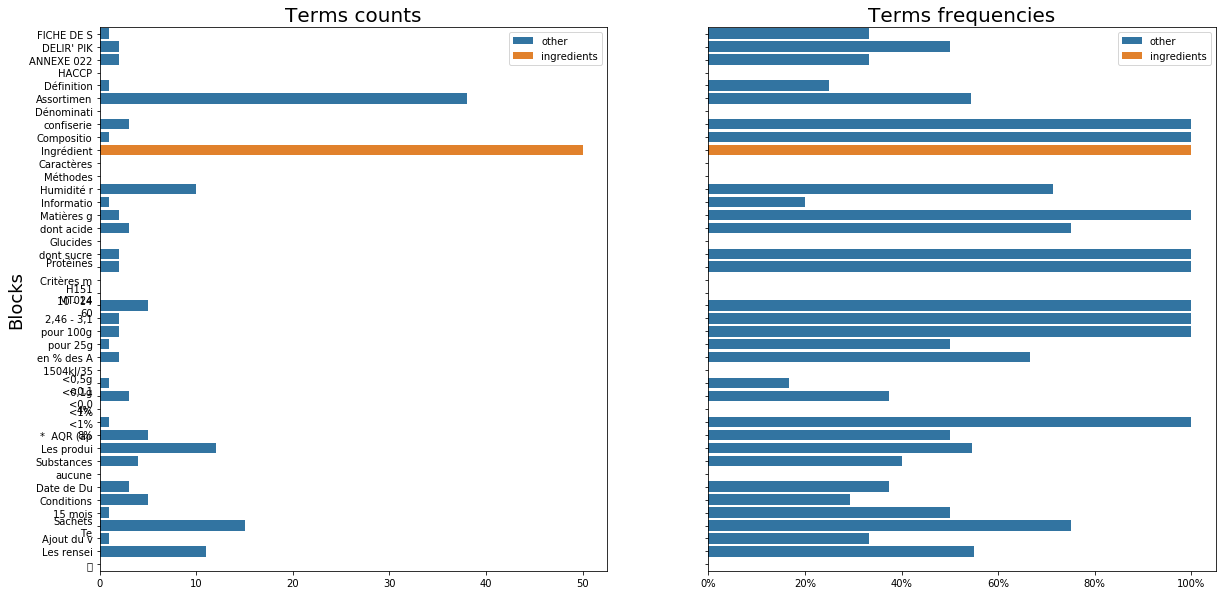

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

colors = ['other'] * len(test_doc_blocks)
colors[true_idx] = 'ingredients'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
sns.barplot(ax=ax[0], x=term_counts, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
sns.barplot(ax=ax[1], x=term_freqs, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
ax[0].set_title('Terms counts', fontsize=20)
ax[0].set_ylabel('Blocks', fontsize=18)
ax[1].set_title('Terms frequencies', fontsize=20)
ax[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
pass

We can see that some very short texts also have an "ingredient word frequency" equal to 100%.

We can draw a scatter plot of these indicators:

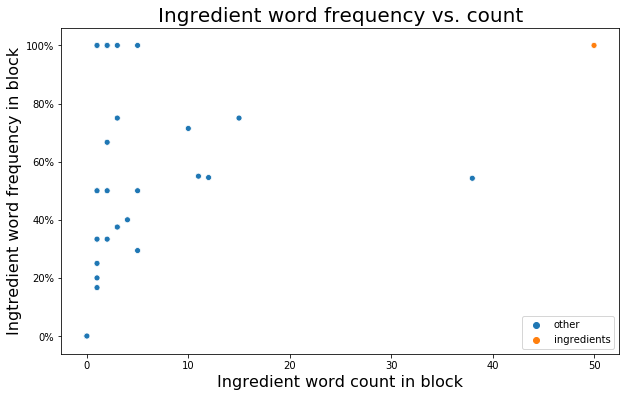

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.scatterplot(ax=ax, x=term_counts, y=term_freqs, hue=colors)
ax.set_title('Ingredient word frequency vs. count', fontsize=20)
ax.set_xlabel('Ingredient word count in block', fontsize=16)
ax.set_ylabel('Ingtredient word frequency in block', fontsize=16)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
pass

As expected, the correct ingredient list is in the top right quadrant of this representation. Should all cases yield results as sharply contrasted, we will have no difficulty in constructing an accurate functionality!

## 4.3 A difficulty arises in assessing ground truth for model validation

### Long strings are seldom strictly equal

We can compare the document ingredient list, with the one stored in the PIM system:

In [23]:
test_doc_blocks[true_idx].replace('\n', '') == df.loc[uid, "Ingrédients"]

False

Because a great deal of the current data in the PIM system has (at least once!) been manually keyed in, it is very likely that there will be an arguably high ratio of mistakes.

In [24]:
print('From pdf file: ')
print(test_doc_blocks[true_idx].replace('\n', ''))
print('--------------------------------------------------------------------------------------')
print('From PIM system:')
print(df.loc[uid, "Ingrédients"])

From pdf file: 
Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: cire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis; sirop de sucre inverti; colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.
--------------------------------------------------------------------------------------
From PIM system:
Ingrédients: sirop de glucose, sucre, gélatine, dextrose, acidifiants: acide citrique, acide malique, agent d'enrobage: cire de carnauba, correcteurs d'acidité: citrate tricalcique, malate acide de sodium, arôme, concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis, sirop de sucre inverti, colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.


One can see that although very close, those 2 texts are somewhat different, from the punctuation marks.

### Different strategies can be undertaken to get around this difficulty

It is mandatory to compare the results of the model with the ground truth to assess the performance of the model. Some workarounds can be set up:

- Ignoring all products that do not have a strict matching block in their pdf file:
    - This will enable for a simple validation process
    - But it might dramatically decreasing the size of our dataset
    - as well as making 'short ingredient list' product overrepresented
    
    
- Defining a softer way to match texts between pdf files and PIM system data **with some text preprocessing** and filtering products that do not have a matching block
    - This will mitigate the previous drawbacks
    - But will increase complexity
    
    
- Defining a softer way to match texts between pdf files and PIM system data **by computing an edition distance** and filtering products that do not have a matching block
    - This will mitigate the previous drawbacks
    - But will increase complexity, as well as requiring to manually set up a distance threshold.
    - This could also lead to have separate pdf file blocks considered ground truth should the threshold distance be too high
    
- Considering blocks n-grams 
    - This might increase the number of 

- Manually labeling some pdf files
    - The most efficient
    - But the most time-consuming too!


# 5. Comparison between PIM system *ground truth* with documents content

We can try to find the products for which the PIM system ingredient list is strictly equal to one of the pdf file blocks.

## 5.1 Retrieving all the blocks from our corpus

The function below enables to retrieve all the blocks as a pandas Series.

In [25]:
%%time
uid_list = list(requester._directory.index)
path_list = [os.path.join('.', 'dumps', 'prd', uid, 'FTF.pdf') for uid in uid_list]
path_series = pd.Series(path_list, index=uid_list)
blocks_series = PDFDecoder.threaded_paths_to_blocks(path_series)

[Errno 2] No such file or directory: '.\\dumps\\prd\\aa6395f4-150a-4d70-b494-bac3bd4893f5\\FTF.pdf'
error at path: .\dumps\prd\aa6395f4-150a-4d70-b494-bac3bd4893f5\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\00f58597-7112-469a-ad9a-328c7a70ed27\\FTF.pdf'
error at path: .\dumps\prd\00f58597-7112-469a-ad9a-328c7a70ed27\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\ee65dc3f-843b-4026-8bf2-b6fd90c51d1b\\FTF.pdf'
error at path: .\dumps\prd\ee65dc3f-843b-4026-8bf2-b6fd90c51d1b\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\482c6620-b6fe-45bb-8fe2-49f79ff85abf\\FTF.pdf'
error at path: .\dumps\prd\482c6620-b6fe-45bb-8fe2-49f79ff85abf\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\71f3391b-5fc6-4a5b-b01e-740522aa216f\\FTF.pdf'
error at path: .\dumps\prd\71f3391b-5fc6-4a5b-b01e-740522aa216f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\7f5530b3-8235-419f-8d2e-0a3427e02021\\FTF.pdf'
error at path: .\dumps\prd\7f5530b3-8235

[Errno 2] No such file or directory: '.\\dumps\\prd\\778b9912-c7bf-48b0-a433-f6db70e052f8\\FTF.pdf'
error at path: .\dumps\prd\778b9912-c7bf-48b0-a433-f6db70e052f8\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\246dda4c-940b-4f1c-9eac-6ebb2ec82b06\\FTF.pdf'
error at path: .\dumps\prd\246dda4c-940b-4f1c-9eac-6ebb2ec82b06\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e15df8cf-af9e-4c52-936d-ead087b09492\\FTF.pdf'
error at path: .\dumps\prd\e15df8cf-af9e-4c52-936d-ead087b09492\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\575fa42c-fbb9-4875-9bc3-0208c559782f\\FTF.pdf'
error at path: .\dumps\prd\575fa42c-fbb9-4875-9bc3-0208c559782f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\09f00fd1-0833-46a4-8cd9-c71eddedb80b\\FTF.pdf'
error at path: .\dumps\prd\09f00fd1-0833-46a4-8cd9-c71eddedb80b\FTF.pdf
Unexpected EOF
error at path: .\dumps\prd\6f8bfabe-0bb1-4862-bb03-5d215e70c72a\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\

[Errno 2] No such file or directory: '.\\dumps\\prd\\f5f2fa6e-70bf-4943-b1bb-06b3a3d458bc\\FTF.pdf'
error at path: .\dumps\prd\f5f2fa6e-70bf-4943-b1bb-06b3a3d458bc\FTF.pdf
Unexpected EOF
error at path: .\dumps\prd\a8a575c1-3c62-40f6-b574-59adbfb5a9bd\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\a39ea643-e794-4fc1-8f7e-952e1c6afa0f\\FTF.pdf'
error at path: .\dumps\prd\a39ea643-e794-4fc1-8f7e-952e1c6afa0f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\9a79a2b7-9d4a-4cee-84bb-595a4b4c006a\\FTF.pdf'
error at path: .\dumps\prd\9a79a2b7-9d4a-4cee-84bb-595a4b4c006a\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\9b6c4c73-d3d4-4c81-9995-13fad9eecc35\\FTF.pdf'
error at path: .\dumps\prd\9b6c4c73-d3d4-4c81-9995-13fad9eecc35\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\64c04ca8-16f8-494e-9cd8-a9939c6d9e25\\FTF.pdf'
error at path: .\dumps\prd\64c04ca8-16f8-494e-9cd8-a9939c6d9e25\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\

[Errno 2] No such file or directory: '.\\dumps\\prd\\b7039452-c153-4b22-9b93-ee66615b90ac\\FTF.pdf'
error at path: .\dumps\prd\b7039452-c153-4b22-9b93-ee66615b90ac\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\0234176b-98f8-4a14-88da-c5d498385821\\FTF.pdf'
error at path: .\dumps\prd\0234176b-98f8-4a14-88da-c5d498385821\FTF.pdf
Unexpected EOF
error at path: .\dumps\prd\1319ea0b-45af-49d1-9208-390cf089ef5d\FTF.pdf
Unexpected EOF
error at path: .\dumps\prd\19d77df9-126e-4f5b-af0d-49e1c200e2a3\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\80e44321-cb1a-4fc0-bae1-d8968f6d8b0c\\FTF.pdf'
error at path: .\dumps\prd\80e44321-cb1a-4fc0-bae1-d8968f6d8b0c\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\f8065b5f-3aa0-48d2-a71e-8fee700f0852\\FTF.pdf'
error at path: .\dumps\prd\f8065b5f-3aa0-48d2-a71e-8fee700f0852\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\815de5a3-2759-4459-895e-a1dbddca5add\\FTF.pdf'
error at path: .\dumps\prd\815de5a3-27

Unexpected EOF
error at path: .\dumps\prd\a28f6d7e-3cd3-45bc-a840-0bdbd281d4a5\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\9f9018a5-4bb1-45e5-8aee-55b79fbe3b4d\\FTF.pdf'
error at path: .\dumps\prd\9f9018a5-4bb1-45e5-8aee-55b79fbe3b4d\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\4097688f-fd5d-4413-9500-5b9e621e223c\\FTF.pdf'
error at path: .\dumps\prd\4097688f-fd5d-4413-9500-5b9e621e223c\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\47242937-a197-40fc-8ac6-cb347a1b0ee1\\FTF.pdf'
error at path: .\dumps\prd\47242937-a197-40fc-8ac6-cb347a1b0ee1\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\594fb383-c8fc-4b35-9e48-e444ae5ece37\\FTF.pdf'
error at path: .\dumps\prd\594fb383-c8fc-4b35-9e48-e444ae5ece37\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\39c703f5-0964-4298-a290-3715f8c171ad\\FTF.pdf'
error at path: .\dumps\prd\39c703f5-0964-4298-a290-3715f8c171ad\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\

[Errno 2] No such file or directory: '.\\dumps\\prd\\7b365ff6-423b-42ff-ab67-67e0c7e4400f\\FTF.pdf'
error at path: .\dumps\prd\7b365ff6-423b-42ff-ab67-67e0c7e4400f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\09591862-0ba8-4c83-a754-d9fafcf8cd1e\\FTF.pdf'
error at path: .\dumps\prd\09591862-0ba8-4c83-a754-d9fafcf8cd1e\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e67eae3c-8bd6-44eb-b176-21596e13d721\\FTF.pdf'
error at path: .\dumps\prd\e67eae3c-8bd6-44eb-b176-21596e13d721\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e2ac2b47-e4e8-461f-bd56-4e89abc01d22\\FTF.pdf'
error at path: .\dumps\prd\e2ac2b47-e4e8-461f-bd56-4e89abc01d22\FTF.pdf
Unexpected EOF
error at path: .\dumps\prd\1c601410-9423-4244-addd-375b54d9b99b\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\bcb88610-fc78-4957-ada4-262af3c36bff\\FTF.pdf'
error at path: .\dumps\prd\bcb88610-fc78-4957-ada4-262af3c36bff\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\

No /Root object! - Is this really a PDF?
error at path: .\dumps\prd\5258975f-09dc-4eb7-bce1-cd7bd107e1e3\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e8b68047-0c34-49c7-ab6f-da5ec460f31f\\FTF.pdf'
error at path: .\dumps\prd\e8b68047-0c34-49c7-ab6f-da5ec460f31f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\fe014d0d-8d6a-493b-85c1-970468c1a500\\FTF.pdf'
error at path: .\dumps\prd\fe014d0d-8d6a-493b-85c1-970468c1a500\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\d92860c1-c252-4aee-82fe-a471de719af6\\FTF.pdf'
error at path: .\dumps\prd\d92860c1-c252-4aee-82fe-a471de719af6\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\916cd845-4f61-40d1-9fc1-8f531af92556\\FTF.pdf'
error at path: .\dumps\prd\916cd845-4f61-40d1-9fc1-8f531af92556\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e71edc70-2b8c-4549-ad7c-a63e417b8275\\FTF.pdf'
error at path: .\dumps\prd\e71edc70-2b8c-4549-ad7c-a63e417b8275\FTF.pdf
[Errno 2] No such file or d

[Errno 2] No such file or directory: '.\\dumps\\prd\\15f8df1e-38e0-4612-9adb-e2775505f229\\FTF.pdf'
error at path: .\dumps\prd\15f8df1e-38e0-4612-9adb-e2775505f229\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\10057adf-2550-4fea-9628-ecf0a0dbb527\\FTF.pdf'
error at path: .\dumps\prd\10057adf-2550-4fea-9628-ecf0a0dbb527\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\fba4a264-de6e-4492-8309-6978c9978038\\FTF.pdf'
error at path: .\dumps\prd\fba4a264-de6e-4492-8309-6978c9978038\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\83427f49-d359-414a-8315-03b9f1ca16d3\\FTF.pdf'
error at path: .\dumps\prd\83427f49-d359-414a-8315-03b9f1ca16d3\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\ba597ab6-9222-44af-9927-779bd0832332\\FTF.pdf'
error at path: .\dumps\prd\ba597ab6-9222-44af-9927-779bd0832332\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\267bb2c5-af36-4c28-ae68-850d0a3a197b\\FTF.pdf'
error at path: .\dumps\prd\267bb2c5-af36

[Errno 2] No such file or directory: '.\\dumps\\prd\\aaae58a5-1371-43e0-8187-cf6d742e7fde\\FTF.pdf'
error at path: .\dumps\prd\aaae58a5-1371-43e0-8187-cf6d742e7fde\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\95c5d8a7-58c8-4126-ad88-fac5fc8f11c4\\FTF.pdf'
error at path: .\dumps\prd\95c5d8a7-58c8-4126-ad88-fac5fc8f11c4\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\1ed158aa-ddec-455e-9537-7c8299a0f105\\FTF.pdf'
error at path: .\dumps\prd\1ed158aa-ddec-455e-9537-7c8299a0f105\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\41ed79ef-48a4-4c94-940b-3c4a7442ccef\\FTF.pdf'
error at path: .\dumps\prd\41ed79ef-48a4-4c94-940b-3c4a7442ccef\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\10df5804-8758-4c6c-a01a-12e276a6303b\\FTF.pdf'
error at path: .\dumps\prd\10df5804-8758-4c6c-a01a-12e276a6303b\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\5a18eebc-eedf-43b3-a190-391d94633679\\FTF.pdf'
error at path: .\dumps\prd\5a18eebc-eedf

[Errno 2] No such file or directory: '.\\dumps\\prd\\a0f3633d-e3e5-4fe4-86dd-daf59a7b4c86\\FTF.pdf'
error at path: .\dumps\prd\a0f3633d-e3e5-4fe4-86dd-daf59a7b4c86\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\5e7cd90b-e5ce-43aa-a9ad-b20cd1030aa4\\FTF.pdf'
error at path: .\dumps\prd\5e7cd90b-e5ce-43aa-a9ad-b20cd1030aa4\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\44af5622-c426-4bf4-8fdc-6286370d7687\\FTF.pdf'
error at path: .\dumps\prd\44af5622-c426-4bf4-8fdc-6286370d7687\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\b29becff-38d1-494e-af81-f0074c1e0d28\\FTF.pdf'
error at path: .\dumps\prd\b29becff-38d1-494e-af81-f0074c1e0d28\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\3e164d70-17f3-4839-b765-bd6acf186c4c\\FTF.pdf'
error at path: .\dumps\prd\3e164d70-17f3-4839-b765-bd6acf186c4c\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\ec2b2567-415d-47d7-8308-4cf1fb8ddfb0\\FTF.pdf'
error at path: .\dumps\prd\ec2b2567-415d

[Errno 2] No such file or directory: '.\\dumps\\prd\\ed481c35-3bab-4621-86a2-596925368691\\FTF.pdf'
error at path: .\dumps\prd\ed481c35-3bab-4621-86a2-596925368691\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\fa1a8fab-0036-448f-987a-49b65940ec25\\FTF.pdf'
error at path: .\dumps\prd\fa1a8fab-0036-448f-987a-49b65940ec25\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\785da5b3-d5cb-4a62-a5ae-d26144a70fc2\\FTF.pdf'
error at path: .\dumps\prd\785da5b3-d5cb-4a62-a5ae-d26144a70fc2\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\29c24246-0178-47c0-9e2f-b794b541ac42\\FTF.pdf'
error at path: .\dumps\prd\29c24246-0178-47c0-9e2f-b794b541ac42\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\de89abd1-b353-4801-896b-a879cc2be814\\FTF.pdf'
error at path: .\dumps\prd\de89abd1-b353-4801-896b-a879cc2be814\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\cb63fcb9-bb56-4bac-82d9-d7ecced3a17e\\FTF.pdf'
error at path: .\dumps\prd\cb63fcb9-bb56

[Errno 2] No such file or directory: '.\\dumps\\prd\\2a11c325-7048-4e3d-93e3-ef56112c33a8\\FTF.pdf'
error at path: .\dumps\prd\2a11c325-7048-4e3d-93e3-ef56112c33a8\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\b33d59dd-e782-4928-bfad-6d66be3ee00e\\FTF.pdf'
error at path: .\dumps\prd\b33d59dd-e782-4928-bfad-6d66be3ee00e\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\8ee43db0-5760-4c97-a5eb-83d91d45250f\\FTF.pdf'
error at path: .\dumps\prd\8ee43db0-5760-4c97-a5eb-83d91d45250f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\62bcfb59-4378-429e-b222-ffb8e7df6523\\FTF.pdf'
error at path: .\dumps\prd\62bcfb59-4378-429e-b222-ffb8e7df6523\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\8c859e8a-a44a-4073-b4fa-75a18d3cc704\\FTF.pdf'
error at path: .\dumps\prd\8c859e8a-a44a-4073-b4fa-75a18d3cc704\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e042b8e6-fb85-4761-9d0d-45f0af3f77f7\\FTF.pdf'
error at path: .\dumps\prd\e042b8e6-fb85

[Errno 2] No such file or directory: '.\\dumps\\prd\\abe78d21-5118-4b02-b877-2b6c763ee075\\FTF.pdf'
error at path: .\dumps\prd\abe78d21-5118-4b02-b877-2b6c763ee075\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\22c14459-b65d-4454-99c4-ec49d97ab14d\\FTF.pdf'
error at path: .\dumps\prd\22c14459-b65d-4454-99c4-ec49d97ab14d\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\b83dbafa-3e98-484b-b621-914c59c18ee5\\FTF.pdf'
error at path: .\dumps\prd\b83dbafa-3e98-484b-b621-914c59c18ee5\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\42866660-7098-4e48-8a89-4926b9d7d4b8\\FTF.pdf'
error at path: .\dumps\prd\42866660-7098-4e48-8a89-4926b9d7d4b8\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\57add800-97c6-4c51-b01a-47dfcb279339\\FTF.pdf'
error at path: .\dumps\prd\57add800-97c6-4c51-b01a-47dfcb279339\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\44972206-a1ef-4ba8-b81e-f66d5886dad3\\FTF.pdf'
error at path: .\dumps\prd\44972206-a1ef

[Errno 2] No such file or directory: '.\\dumps\\prd\\2558e010-3d56-4328-b6e0-8df2a94db098\\FTF.pdf'
error at path: .\dumps\prd\2558e010-3d56-4328-b6e0-8df2a94db098\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\a40d51e5-0d83-40cc-b03e-f453346a53ff\\FTF.pdf'
error at path: .\dumps\prd\a40d51e5-0d83-40cc-b03e-f453346a53ff\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\610afb61-095a-42ea-854b-05d4d7eb849e\\FTF.pdf'
error at path: .\dumps\prd\610afb61-095a-42ea-854b-05d4d7eb849e\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\88507d81-ae18-450b-bdd7-24ae73eb3b67\\FTF.pdf'
error at path: .\dumps\prd\88507d81-ae18-450b-bdd7-24ae73eb3b67\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\bcffb35e-8c05-48ff-a94b-8ad949cf62aa\\FTF.pdf'
error at path: .\dumps\prd\bcffb35e-8c05-48ff-a94b-8ad949cf62aa\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\f6a9a61c-08ad-470b-9ccd-dc745152d072\\FTF.pdf'
error at path: .\dumps\prd\f6a9a61c-08ad

[Errno 2] No such file or directory: '.\\dumps\\prd\\d8095d42-363f-4c55-aae9-a0ecd1e37e35\\FTF.pdf'
error at path: .\dumps\prd\d8095d42-363f-4c55-aae9-a0ecd1e37e35\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\11dd291a-6ed2-40c0-8041-79ec47469726\\FTF.pdf'
error at path: .\dumps\prd\11dd291a-6ed2-40c0-8041-79ec47469726\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\9b4d820e-9694-423f-b039-a52328c006bf\\FTF.pdf'
error at path: .\dumps\prd\9b4d820e-9694-423f-b039-a52328c006bf\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\0d688623-66a0-4a27-a81d-460d7c62c55c\\FTF.pdf'
error at path: .\dumps\prd\0d688623-66a0-4a27-a81d-460d7c62c55c\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\6adc2691-f85f-48fb-ae2a-cde8099fb49b\\FTF.pdf'
error at path: .\dumps\prd\6adc2691-f85f-48fb-ae2a-cde8099fb49b\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\4c4a334c-3cdd-4346-ab40-169a6674b3e0\\FTF.pdf'
error at path: .\dumps\prd\4c4a334c-3cdd

[Errno 2] No such file or directory: '.\\dumps\\prd\\3ec9cc99-7ba2-449d-afc7-b22e465a192a\\FTF.pdf'
error at path: .\dumps\prd\3ec9cc99-7ba2-449d-afc7-b22e465a192a\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\4f5de3b5-68a9-42c6-9bf8-3e22cda01d9d\\FTF.pdf'
error at path: .\dumps\prd\4f5de3b5-68a9-42c6-9bf8-3e22cda01d9d\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\8cf40a8c-5f8e-4515-865f-01f58eb230df\\FTF.pdf'
error at path: .\dumps\prd\8cf40a8c-5f8e-4515-865f-01f58eb230df\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\5b772f1c-163d-4069-9ce8-776f297025c2\\FTF.pdf'
error at path: .\dumps\prd\5b772f1c-163d-4069-9ce8-776f297025c2\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\1fb530f2-8639-4d8f-85c2-dbde453d3bd1\\FTF.pdf'
error at path: .\dumps\prd\1fb530f2-8639-4d8f-85c2-dbde453d3bd1\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\3e267ea8-9d0e-42b8-bc63-ac7f9a462406\\FTF.pdf'
error at path: .\dumps\prd\3e267ea8-9d0e

[Errno 2] No such file or directory: '.\\dumps\\prd\\c75a83f6-c280-4708-a568-274ff1515c7c\\FTF.pdf'
error at path: .\dumps\prd\c75a83f6-c280-4708-a568-274ff1515c7c\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\c4fad935-4682-4da6-a047-c947525d2a66\\FTF.pdf'
error at path: .\dumps\prd\c4fad935-4682-4da6-a047-c947525d2a66\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\527bac39-65b4-4c6a-b20c-83ca56ee02c1\\FTF.pdf'
error at path: .\dumps\prd\527bac39-65b4-4c6a-b20c-83ca56ee02c1\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\fa380ee9-008e-4b6b-9bcc-c2fb5f1613a7\\FTF.pdf'
error at path: .\dumps\prd\fa380ee9-008e-4b6b-9bcc-c2fb5f1613a7\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\a02fba9d-4025-4e6f-8fb2-1028d303fd2a\\FTF.pdf'
error at path: .\dumps\prd\a02fba9d-4025-4e6f-8fb2-1028d303fd2a\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\3aa12bd5-d53d-4c3c-8286-cecbf798b543\\FTF.pdf'
error at path: .\dumps\prd\3aa12bd5-d53d

[Errno 2] No such file or directory: '.\\dumps\\prd\\f0074930-df33-43ed-8523-d5acb5a5eb6f\\FTF.pdf'
error at path: .\dumps\prd\f0074930-df33-43ed-8523-d5acb5a5eb6f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\f80d2676-10b9-4dcc-9c6a-b9b7a2cf6e71\\FTF.pdf'
error at path: .\dumps\prd\f80d2676-10b9-4dcc-9c6a-b9b7a2cf6e71\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\72e1b841-591b-4304-a0e6-4518164e8b41\\FTF.pdf'
error at path: .\dumps\prd\72e1b841-591b-4304-a0e6-4518164e8b41\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\8fe3ce5d-7a4f-46a8-aae5-e1419e7d04d7\\FTF.pdf'
error at path: .\dumps\prd\8fe3ce5d-7a4f-46a8-aae5-e1419e7d04d7\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\0e4b0b8b-1b60-43a7-ae1f-924c65db18fd\\FTF.pdf'
error at path: .\dumps\prd\0e4b0b8b-1b60-43a7-ae1f-924c65db18fd\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e4f92fec-26c6-4e78-992d-9ad65b35d458\\FTF.pdf'
error at path: .\dumps\prd\e4f92fec-26c6

[Errno 2] No such file or directory: '.\\dumps\\prd\\ef4d7686-908b-4d98-bd6b-4a6f159cf9a0\\FTF.pdf'
error at path: .\dumps\prd\ef4d7686-908b-4d98-bd6b-4a6f159cf9a0\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\7bdc02f7-1e3e-4db8-8a67-e50ce3bd1b80\\FTF.pdf'
error at path: .\dumps\prd\7bdc02f7-1e3e-4db8-8a67-e50ce3bd1b80\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\c7a62f4c-69b4-4c7a-ad93-f939791aff70\\FTF.pdf'
error at path: .\dumps\prd\c7a62f4c-69b4-4c7a-ad93-f939791aff70\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\762eeda4-c72c-4f71-ac07-9ac7061e3e57\\FTF.pdf'
error at path: .\dumps\prd\762eeda4-c72c-4f71-ac07-9ac7061e3e57\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\687be65d-4db1-4c02-a55f-e06faf1c8d48\\FTF.pdf'
error at path: .\dumps\prd\687be65d-4db1-4c02-a55f-e06faf1c8d48\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\0d404cad-f849-422a-8912-17f064dc9101\\FTF.pdf'
error at path: .\dumps\prd\0d404cad-f849

[Errno 2] No such file or directory: '.\\dumps\\prd\\969b09d7-c03c-4ecc-ba35-ad8496ce5b9f\\FTF.pdf'
error at path: .\dumps\prd\969b09d7-c03c-4ecc-ba35-ad8496ce5b9f\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e580468e-7bfd-44d0-b9c4-65a11cda40ab\\FTF.pdf'
error at path: .\dumps\prd\e580468e-7bfd-44d0-b9c4-65a11cda40ab\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\6e0567db-47c0-49b8-9589-05332599d2e2\\FTF.pdf'
error at path: .\dumps\prd\6e0567db-47c0-49b8-9589-05332599d2e2\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\316054f7-9720-4439-ae35-483faa9a2d5b\\FTF.pdf'
error at path: .\dumps\prd\316054f7-9720-4439-ae35-483faa9a2d5b\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\92aaa50a-952b-4109-91c0-d3bffcc9f79a\\FTF.pdf'
error at path: .\dumps\prd\92aaa50a-952b-4109-91c0-d3bffcc9f79a\FTF.pdf
[Errno 2] No such file or directory: '.\\dumps\\prd\\e4a757ca-7762-47a2-b303-8f1f66a6e10e\\FTF.pdf'
error at path: .\dumps\prd\e4a757ca-7762

In [77]:
blocks_series.rename('pdf_blocks', inplace=True)
blocks_series.index.rename('uid', inplace=True)
blocks_series

uid
58f67e91-6d16-4f12-97c7-e67d24be6805                               DESCRIPTION DU PRODUIT
58f67e91-6d16-4f12-97c7-e67d24be6805                                      FICHE TECHNIQUE
58f67e91-6d16-4f12-97c7-e67d24be6805                                     CURCUMA MOULU PK
58f67e91-6d16-4f12-97c7-e67d24be6805                       Liste des ingrédients\nCurcuma
58f67e91-6d16-4f12-97c7-e67d24be6805                     114101\nIndice :\nDate :\nPage :
                                                              ...                        
6d8917a4-ede6-4765-9721-14cae30a25bf                                                     
6d8917a4-ede6-4765-9721-14cae30a25bf    Charles Faraud S.A.S. au capital de 3.623.130 ...
6d8917a4-ede6-4765-9721-14cae30a25bf                                                     
6d8917a4-ede6-4765-9721-14cae30a25bf                                                    

ad146287-3f4c-4c42-8b39-537a64faf0e7                                                     
Name: 

As it takes some time to run the pdf parsing on all the corpus, we save it in a csv.

In [78]:
import datetime
timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
blocks_series.to_csv(os.path.join('.', 'dumps', 'prd', 'blocks_'+ timestamp + '.csv'), header=True)

## 5.2 Comparing blocks with PIM ingredient lists

We only keep products with ingredient list.

In [69]:
df_ingred = df.loc[pd.notna(df['Ingrédients'])]
df_ingred

,Libellé,Ingrédients
uid,,
34d33a48-5735-49ec-a08f-6642933dec00,Préparation de concentré de citron et d'aneth ...,Préparation aux jus de citron & aneth (condime...
d45d3058-f7d5-4cb8-be37-99bcc2ed06e9,Ecume de saveurs en bouteille 150 ml MISS ALGAE,Préparation de jus de yuzu ( condiment de bals...
47b861bc-42bc-4f7e-9b76-a6d4504b3907,Pain spécial burger à la semoule de blé 72 g H...,"Farine de BLÉ 59%, eau, levure, dextrose, semo..."
d81eae2e-0232-46f8-b058-bdc1e6b7a64e,Ketchup en flacon souple 220 ml HEINZ,"Tomates (148 g pour 100 g de ketchup), vinaigr..."
abd31acd-e2d9-437a-9588-5bf0d0f3f059,Confit de canard du Gers IGP en boîte 2/1 CANA...,"Cuisses de canard confites, graisse de canard,..."
...,...,...
53f966c0-0acc-4931-9bbc-481424c80427,CHIPS BRETS SAVEUR POIVRONS GRILLES CHORIZO 125G,"Pommes de terre (France) (61,9%), huile de tou..."
f1a777bb-d39d-4ab7-af16-253f0d3d8b57,CHIPS BRETS NATURE CRAQUANTE 125G,"Pommes de terre (France) (64,9%), huile de tou..."
ee2a60ff-581f-4c7b-968b-5e7983b3c5ff,HARICOTS VERTS EXTRA FINS 4/4 EPISAVEURS,"haricots verts , eau, sel"


Among these products with an ingredient list, we only keep the ones which have (at least) a block from the pdf that is strictly matching its PIM ingredient list:

In [100]:
joined_df = df_ingred.join(blocks_series)
matching = joined_df.loc[joined_df['Ingrédients'] == joined_df['pdf_blocks']].drop_duplicates()
matching

,Libellé,Ingrédients,pdf_blocks
uid,,,
00e1b971-5963-4900-b43d-0ee955065e8c,Miel d'acacia en pot verre 30 g BONNE MAMAN,Miel,Miel
01481218-1568-434a-9495-5b82a3d4ed5b,"Tartelette sablée diam 8,5 cm JEAN DUCOURTIEUX",Farine de BLE - Sucre - Huile de palme - Blanc...,Farine de BLE - Sucre - Huile de palme - Blanc...
01972ec5-aba3-4b97-b112-cfb247cde89d,CORNICHONS ENTIERS SANS SEL MI FINS 60+ EN BOÎ...,"Cornichons (UE / Macédoine), eau, vinaigre, ar...","Cornichons (UE / Macédoine), eau, vinaigre, ar..."
0238f6c8-1aa1-4cb4-adfa-34d67e8a9861,Laurier en feuille en sachet 500 g LA CASE AUX...,Laurier feuilles,Laurier feuilles
02a4a5cd-3093-4213-9e24-7f1ad456f5a0,Lentilles en poche 4 kg BONDUELLE,"Lentilles sèches trempées (BLE), eau, sel.","Lentilles sèches trempées (BLE), eau, sel."
...,...,...,...
fafc2880-28e0-4352-befb-80e041ad93b0,Haricots rouges en boîte 3/1 BONDUELLE,"Eau, haricots rouges secs trempés, sel, concen...","Eau, haricots rouges secs trempés, sel, concen..."
fce0b885-f7a8-4147-9b1d-0a83ee2e9626,Morillon séché en boîte 500 g BAUDOIN,100% Morillons - Ptycoverpa bohemica,100% Morillons - Ptycoverpa bohemica
fd0dd6cf-8628-4e8f-8c55-93d3d4bb53c8,Purée pomme-poire en pot 130 g BLEDINA,"Poires 99,90 % - Jus de citron concentré - Vit...","Poires 99,90 % - Jus de citron concentré - Vit..."


We can see that only keeping products with strict equality between PIM ingredient list and any of the pdf blocks has dramatically reduced their number: from 9549 to 299. New sample size only represents less than 3.5% of the initial set.

,Libellé,Ingrédients,pdf_blocks
uid,,,
00e1b971-5963-4900-b43d-0ee955065e8c,Miel d'acacia en pot verre 30 g BONNE MAMAN,Miel,Miel
01481218-1568-434a-9495-5b82a3d4ed5b,"Tartelette sablée diam 8,5 cm JEAN DUCOURTIEUX",Farine de BLE - Sucre - Huile de palme - Blanc...,Farine de BLE - Sucre - Huile de palme - Blanc...
01972ec5-aba3-4b97-b112-cfb247cde89d,CORNICHONS ENTIERS SANS SEL MI FINS 60+ EN BOÎ...,"Cornichons (UE / Macédoine), eau, vinaigre, ar...","Cornichons (UE / Macédoine), eau, vinaigre, ar..."
0238f6c8-1aa1-4cb4-adfa-34d67e8a9861,Laurier en feuille en sachet 500 g LA CASE AUX...,Laurier feuilles,Laurier feuilles
02a4a5cd-3093-4213-9e24-7f1ad456f5a0,Lentilles en poche 4 kg BONDUELLE,"Lentilles sèches trempées (BLE), eau, sel.","Lentilles sèches trempées (BLE), eau, sel."
...,...,...,...
fafc2880-28e0-4352-befb-80e041ad93b0,Haricots rouges en boîte 3/1 BONDUELLE,"Eau, haricots rouges secs trempés, sel, concen...","Eau, haricots rouges secs trempés, sel, concen..."
fce0b885-f7a8-4147-9b1d-0a83ee2e9626,Morillon séché en boîte 500 g BAUDOIN,100% Morillons - Ptycoverpa bohemica,100% Morillons - Ptycoverpa bohemica
fd0dd6cf-8628-4e8f-8c55-93d3d4bb53c8,Purée pomme-poire en pot 130 g BLEDINA,"Poires 99,90 % - Jus de citron concentré - Vit...","Poires 99,90 % - Jus de citron concentré - Vit..."


## Different strategies

TODO !!!

But The similarity between the ground truth (the pdf file) and the content of the PIM system can be measured via the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance is the number of character insertions, deletions or substitutions to get from one text to the other.

If we compute this distance between the pdf file block and the PIM system content we get:

In [29]:
import jellyfish
dist = jellyfish.levenshtein_distance(test_doc_blocks[true_idx].replace('\n', ''),
                                      df.loc[uid, "Ingrédients"])
print(f'Levenshtein distance between pdf file and PIM system content is: {dist}')

Levenshtein distance between pdf file and PIM system content is: 11


We can compute this distance for each block in our pdf file, and plot it in a bar graph:

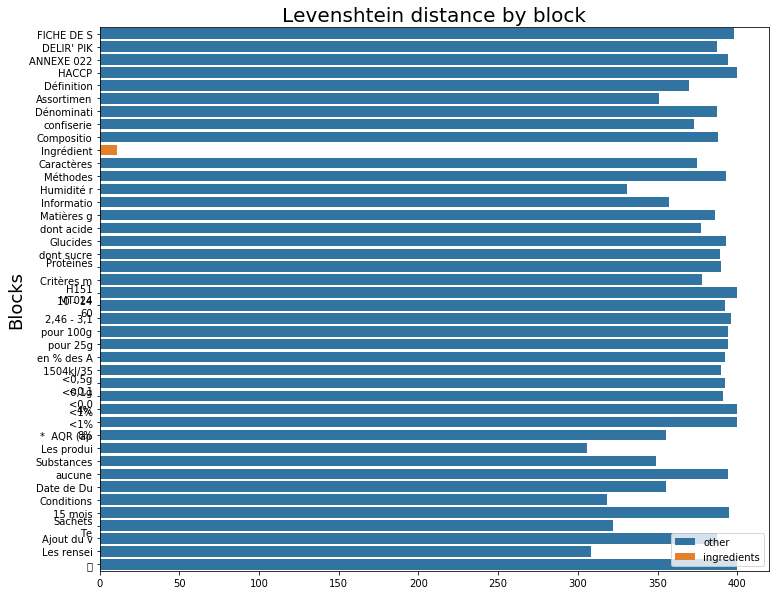

In [30]:
distances = list(map(lambda x:jellyfish.levenshtein_distance(x.replace('\n', ''), df.loc[uid, "Ingrédients"]),
                 test_doc_blocks))
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(ax=ax, x=distances, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
ax.set_title('Levenshtein distance by block', fontsize=20)
ax.set_ylabel('Blocks', fontsize=18)
pass

## 4.2 Making prediction on a document